#unzip, pip

In [1]:
!unzip /content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/open.zip #약 10분

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train_img/TRAIN_2140.png  
  inflating: train_img/TRAIN_2141.png  
  inflating: train_img/TRAIN_2142.png  
  inflating: train_img/TRAIN_2143.png  
  inflating: train_img/TRAIN_2144.png  
  inflating: train_img/TRAIN_2145.png  
  inflating: train_img/TRAIN_2146.png  
  inflating: train_img/TRAIN_2147.png  
  inflating: train_img/TRAIN_2148.png  
  inflating: train_img/TRAIN_2149.png  
  inflating: train_img/TRAIN_2150.png  
  inflating: train_img/TRAIN_2151.png  
  inflating: train_img/TRAIN_2152.png  
  inflating: train_img/TRAIN_2153.png  
  inflating: train_img/TRAIN_2154.png  
  inflating: train_img/TRAIN_2155.png  
  inflating: train_img/TRAIN_2156.png  
  inflating: train_img/TRAIN_2157.png  
  inflating: train_img/TRAIN_2158.png  
  inflating: train_img/TRAIN_2159.png  
  inflating: train_img/TRAIN_2160.png  
  inflating: train_img/TRAIN_2161.png  
  inflating: train_img/TRAIN_2162.png  
  inflating: train_img/TRAIN_2163.png  
  in

#model

In [2]:
import numpy as np
import pandas as pd
from typing import List, Union
from joblib import Parallel, delayed


def rle_decode(mask_rle: Union[str, int], shape=(224, 224)) -> np.array:
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    if mask_rle == -1:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7) -> float:
    '''
    Calculate Dice Score between two binary masks.
    '''
    intersection = np.sum(prediction * ground_truth)
    return (2.0 * intersection + smooth) / (np.sum(prediction) + np.sum(ground_truth) + smooth)


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)) -> List[float]:
    '''
    Calculate Dice scores for a dataset.
    '''


    # Keep only the rows in the prediction dataframe that have matching img_ids in the ground truth dataframe
    #prediction_df = prediction_df[prediction_df.iloc[:, 0].isin(ground_truth_df.iloc[:, 0])]
    #prediction_df.index = range(prediction_df.shape[0])


    # Extract the mask_rle columns
    #pred_mask_rle = prediction_df.iloc[:, 1]
    #gt_mask_rle = ground_truth_df.iloc[:, 1]
    pred_mask_rle = prediction_df
    gt_mask_rle = ground_truth_df


    def calculate_dice(pred_rle, gt_rle):
        #pred_mask = rle_decode(pred_rle, img_shape)
        #gt_mask = rle_decode(gt_rle, img_shape)
        pred_mask = pred_rle
        gt_mask = gt_rle

        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None


    dice_scores = Parallel(n_jobs=-1)(
        delayed(calculate_dice)(pred_rle, gt_rle) for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle)
    )


    dice_scores = [score for score in dice_scores if score is not None]  # Exclude None values


    return np.mean(dice_scores)

In [3]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import RandomCrop, Compose
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),  # 좌우 대칭
        A.VerticalFlip(p=0.5),    # 상하 대칭
        A.Rotate(limit=180, p=0.5),  # 90도 회전
        A.RandomCrop(224,224),
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)


class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, is_validation=False, is_test=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        if(is_test):
          pass
        elif(is_validation):
          self.data = self.data[6500:]
        else:
          self.data = self.data[:6500]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform: #infer는 test_transform으로
                image = test_transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask


# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

def train():
    # training loop
    for epoch in range(30):  # 10 에폭 동안 학습합니다.
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        model.eval()
        vali_epoch_loss=0
        dice_score = 0
        for images, masks in tqdm(vali_dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = np.squeeze(preds, axis=1)
            preds = (preds > 0.5).astype(np.uint8) # Threshold = 0.35

            vali_epoch_loss += loss.item()

            masks = masks.detach().cpu().numpy()

            dice_score+=calculate_dice_scores(masks,preds) * len(images)

        print(f'Epoch {epoch+1}, train_Loss: {epoch_loss/len(dataloader)} vali_loss: {vali_epoch_loss/len(vali_dataloader)} dice_score: {dice_score/len(vali_dataset)}')

def vali_inference():
  with torch.no_grad():
     model.eval()
     dice_score=0
     for images, masks in tqdm(vali_dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            preds = np.squeeze(preds, axis=1)
            preds = (preds > 0.5).astype(np.uint8) # Threshold = 0.35

            masks = masks.detach().cpu().numpy()

            dice_score+=calculate_dice_scores(masks,preds) * len(images)
     print(f"dice score for validation: {dice_score/len(vali_dataset)}")

def inference():
    with torch.no_grad():
        model.eval()
        result = []
        for images in tqdm(test_dataloader):
            images = images.float().to(device)

            outputs = model(images)
            masks = torch.sigmoid(outputs).cpu().numpy()
            masks = np.squeeze(masks, axis=1)
            masks = (masks > 0.5).astype(np.uint8) # Threshold = 0.35

            #for i in range(len(masks)):
            #  mask = masks[i]
            #  if(len(mask[mask==1])<1000):
            #    mask[mask==1]=0
            #    masks[i]=mask


            for i in range(len(images)):
                mask_rle = rle_encode(masks[i])
                if len(mask_rle.split()) < 10: # 예측된 건물 픽셀이 아예 없는 경우 -1
                    result.append(-1)
                else:
                    result.append(mask_rle)
        submit = pd.read_csv('./sample_submission.csv')
        submit['mask_rle'] = result
        submit.to_csv('/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/submit_20230707.csv', index=False)


In [5]:
# 저장한 모델 불러오기
model = UNet().to(device)
#model.load_state_dict(torch.load('/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/model/unet_model_20230706.pt'))

# model 초기화
#model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


batch_size=32

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

vali_dataset = SatelliteDataset(csv_file='./train.csv', transform=transform,is_validation=True)
vali_dataloader = DataLoader(vali_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True,is_test=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


print(len(dataset))
print(len(vali_dataset))
print(len(test_dataset))

print()

print(len(dataloader))
print(len(vali_dataloader))
print(len(test_dataloader))

#"checking error"
dataset[1]
vali_dataset[1]
test_dataset[1]
print("dataset finished")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


6500
640
60640

204
20
1895
dataset finished


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [45]:
torch.cuda.empty_cache()

In [ ]:
train()  # 모델 훈련
#모델 저장
torch.save(model.state_dict(),'/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/model/unet_model_20230707.pt')


100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


Epoch 1, train_Loss: 0.2153324865389104 vali_loss: 0.17723122462630272 dice_score: 0.09036555829389756


100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Epoch 2, train_Loss: 0.1760517702090974 vali_loss: 0.1725279115140438 dice_score: 0.043642420816663606


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Epoch 3, train_Loss: 0.1569297858057361 vali_loss: 0.1589581061154604 dice_score: 0.1041255508032328


100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


Epoch 4, train_Loss: 0.14362087213963853 vali_loss: 0.16713894121348857 dice_score: 0.20440954959899757


100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


Epoch 5, train_Loss: 0.13907403444104335 vali_loss: 0.14057856872677804 dice_score: 0.3293558503883372


100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


Epoch 6, train_Loss: 0.12646933684728162 vali_loss: 0.12070234343409539 dice_score: 0.4237936678306147


100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


Epoch 7, train_Loss: 0.11515000396791626 vali_loss: 0.13093237653374673 dice_score: 0.44433825844779323


100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Epoch 8, train_Loss: 0.11405806955607499 vali_loss: 0.11618534326553345 dice_score: 0.4411324574027547


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


Epoch 9, train_Loss: 0.10652167068830892 vali_loss: 0.11051068734377623 dice_score: 0.4596459324713621


100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


Epoch 10, train_Loss: 0.1031428021287509 vali_loss: 0.10216087512671948 dice_score: 0.4827348987408528


100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


Epoch 11, train_Loss: 0.10031034214896899 vali_loss: 0.09812474101781846 dice_score: 0.5412578101338571


100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


Epoch 12, train_Loss: 0.0973556338279855 vali_loss: 0.09891256131231785 dice_score: 0.5637147893382715


 51%|█████▏    | 105/204 [02:28<02:28,  1.50s/it]

In [ ]:
vali_inference()

In [ ]:
inference()

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/model/unet_model_20230707.pt')

#시각화 위한 dataset

In [ ]:
#crop 결과 시각화를 위한 dataset
%cd /content/
class plt_Dataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = A.Compose(
          [
              A.HorizontalFlip(p=0.5),  # 좌우 대칭
              A.VerticalFlip(p=0.5),    # 상하 대칭
              #A.Rotate(limit=180, p=0.5),  # 90도 회전
              A.RandomCrop(224,224),
              A.Resize(224, 224),
              ToTensorV2()
          ]
        )
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

plt_dataset = plt_Dataset(csv_file='./train.csv')

/content


In [ ]:
#crop 결과 시각화를 위한 dataset
class plt_test_Dataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = A.Compose(
          [

              A.RandomCrop(224,224),
              A.Resize(224, 224),
              ToTensorV2()
          ]
        )
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

plt_test_dataset = plt_test_Dataset(csv_file='./test.csv',infer=True)

# train data 시각화

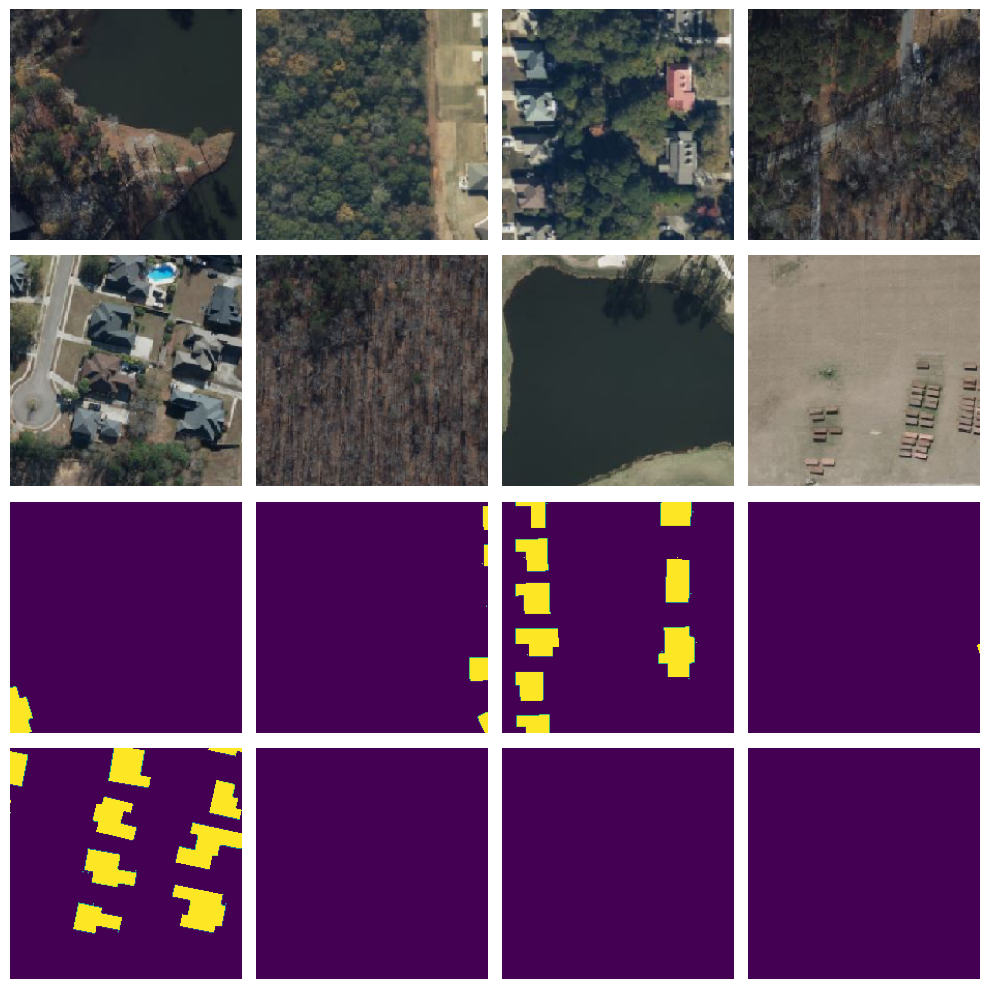

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

idx = 1
image_see = []
mask_see = []
for i in range(idx,idx+8):
  image, mask = plt_dataset[i]
  image_see.append(image)
  mask_see.append(mask)

image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)

def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()



#test 결과 시각화

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

idx = 0
image_see = []
mask_see = []
for i in range(idx,idx+8):
  #image = plt_test_dataset[i]
  image , _ = plt_dataset[i]
  image_see.append(image)

  image = image.float().to(device)
  outputs = model(image.view(1,3,224,224))
  print(outputs)
  mask = torch.sigmoid(outputs).detach().cpu().numpy()
  mask = np.squeeze(mask, axis=1)
  mask = mask.reshape(224,224)
  mask = (mask > 0.5).astype(np.uint8) # Threshold = 0.35

  #print(len(mask[mask==1]))

  #mask_see.append(mask)

image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)


def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()



5263
4780
2661
710
3632
2753
6154
2060


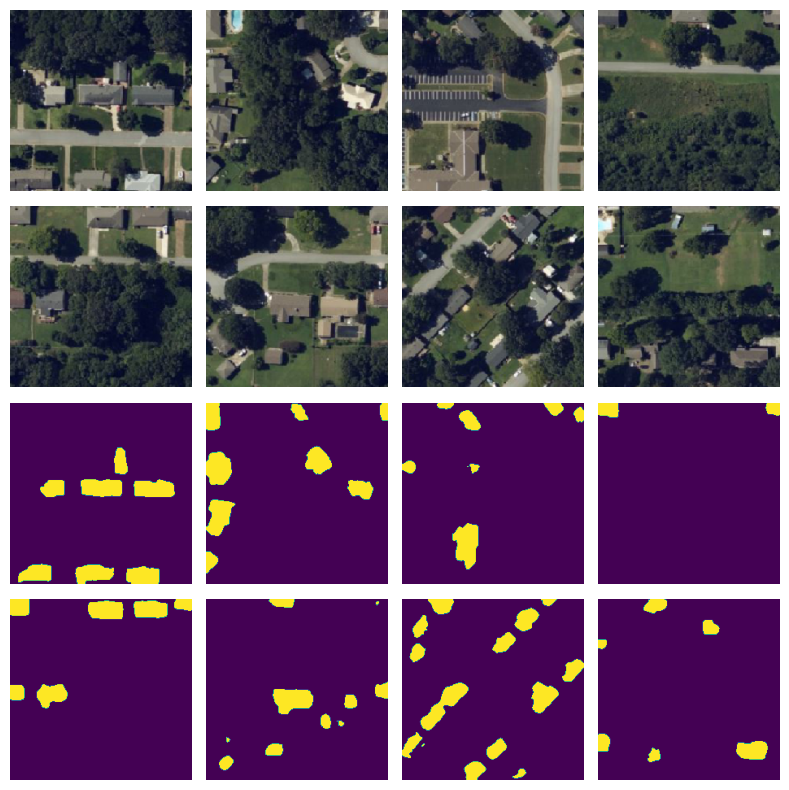

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

idx = 80

image_see = []
mask_see = []

submit_csv = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/submit_20230707.csv')
new_submit_csv = submit_csv.copy()

for i in range(idx,idx+8):
  image = plt_test_dataset[i]
  image_see.append(image)

  mask = submit_csv['mask_rle'][i]
  mask = rle_decode(mask,(224,224))
  print(len(mask[mask==1]))

  #if(len(mask[mask==1])<1000):
  #  mask[mask==1]=0
  #  new_mask = rle_encode(mask)
  #  new_submit_csv['mask_rle'][i] = -1

  mask_see.append(mask)

image_see = np.stack(image_see, axis=0)
mask_see = np.stack(mask_see, axis=0)

def plot_normalized_images(images, masks):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(len(images)):
        image = np.transpose(images[i], (1, 2, 0))
        axes[i].imshow(image)
        axes[i].axis('off')

    for i in range(len(masks)):
        axes[i+len(images)].imshow(masks[i])
        axes[i+len(images)].axis('off')

# 이미지 시각화
plot_normalized_images(image_see, mask_see)

plt.tight_layout()
plt.show()



In [ ]:
new_submit_csv.to_csv("/content/drive/MyDrive/Colab_Notebooks/2023_성균관대_segmentation대회/submit_20230706.csv",index=False)

In [ ]:
new_submit_csv.head(10)

,img_id,mask_rle
0,TEST_00000,12358 2 12580 6 12800 1 12803 6 12854 4 13023 ...
1,TEST_00001,2 3 7 4 226 3 232 3 451 1 456 3 681 2 1016 1 1...
2,TEST_00002,-1
3,TEST_00003,21 16 54 2 236 25 278 2 460 25 501 3 686 24 72...
4,TEST_00004,13665 2 13889 2 14113 2 14337 2 14561 2 14785 ...
5,TEST_00005,15083 4 15307 8 15531 8 15756 7 16651 1 16875 ...
6,TEST_00006,399 3 544 4 598 3 603 2 621 6 638 2 768 4 822 ...
7,TEST_00007,-1
8,TEST_00008,56 4 279 5 503 5 526 3 532 3 727 5 750 3 756 4...
9,TEST_00009,171 7 395 8 621 6 845 6 1011 5 1069 6 1235 5 1...


In [ ]:
submit_csv.head(10)

,img_id,mask_rle
0,TEST_00000,12358 2 12580 6 12800 1 12803 6 12854 4 13023 ...
1,TEST_00001,2 3 7 4 226 3 232 3 451 1 456 3 681 2 1016 1 1...
2,TEST_00002,236 1 459 3 515 3 739 3 963 3 1177 3 1186 4 14...
3,TEST_00003,21 16 54 2 236 25 278 2 460 25 501 3 686 24 72...
4,TEST_00004,13665 2 13889 2 14113 2 14337 2 14561 2 14785 ...
5,TEST_00005,15083 4 15307 8 15531 8 15756 7 16651 1 16875 ...
6,TEST_00006,399 3 544 4 598 3 603 2 621 6 638 2 768 4 822 ...
7,TEST_00007,-1
8,TEST_00008,56 4 279 5 503 5 526 3 532 3 727 5 750 3 756 4...
9,TEST_00009,171 7 395 8 621 6 845 6 1011 5 1069 6 1235 5 1...


In [ ]:
import numpy as np

# 이미지 배열 생성 (0과 1로 이루어진 예시)
image = np.array([
    [1, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 0, 1, 1],
    [1, 1, 0, 0]
])

# 이미지 배열의 크기
height, width = image.shape

# 이미지 배열을 방문했는지를 나타내는 배열
visited = np.zeros_like(image)

# 상하좌우로 인접한 픽셀을 탐색하는 DFS 함수
def dfs(i, j):
    # 현재 픽셀을 방문했음을 표시
    visited[i, j] = 1

    # 상하좌우로 인접한 픽셀을 확인하면서 1인 경우에 대해 DFS 수행
    if i > 0 and image[i-1, j] == 1 and visited[i-1, j] == 0:
        dfs(i-1, j)
    if i < height-1 and image[i+1, j] == 1 and visited[i+1, j] == 0:
        dfs(i+1, j)
    if j > 0 and image[i, j-1] == 1 and visited[i, j-1] == 0:
        dfs(i, j-1)
    if j < width-1 and image[i, j+1] == 1 and visited[i, j+1] == 0:
        dfs(i, j+1)

# 붙어있는 1의 개수를 세는 함수
def count_connected_ones(image):
    count = 0

    # 이미지 배열의 모든 픽셀을 확인하면서 DFS 수행
    for i in range(height):
        for j in range(width):
            if image[i, j] == 1 and visited[i, j] == 0:
                dfs(i, j)
                count += 1

    return count

# 붙어있는 1의 개수가 4 이상인 경우 해당 픽셀을 0으로 변경
for i in range(height):
    for j in range(width):
        if image[i, j] == 1:
            # 붙어있는 1의 개수 세기
            visited = np.zeros_like(image)
            connected_count = count_connected_ones(image)

            # 4 이상인 경우 해당 픽셀을 0으로 변경
            if connected_count >= 4:
                image[i, j] = 0

# 결과 출력
print(image)

[[1 1 0 0]
 [0 0 1 1]
 [0 0 1 1]
 [1 1 0 0]]
